# Experimento 1
***
- Conjuntos de dados: Montgomery + Shenzen
- Testando a equalização de histograma em comparação com a mudança típica de escala

### Importando os pacotes necessários

In [26]:
import glob
import re
from tqdm import tqdm
import urllib.request
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

### Pré-processando os dados

In [4]:
# coletando o caminho dos arquivos dos dados do hospital shenzen
filelist_shenzen = glob.glob('/content/drive/MyDrive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/*.png')
# coletando o caminho dos arquivos dos dados do hospital montgomery
filelist_montgomery = glob.glob('/content/drive/MyDrive/Montgomery/MontgomerySet/CXR_png/*.png')
# juntando os dois datasets
filelist = filelist_shenzen + filelist_montgomery

In [5]:
# quantidade de imagens disponíveis no dataset
print('quantidade de imagens:', str(len(filelist)))

quantidade de imagens: 662


In [6]:
def extract_label(file_list):
    
    # inicializando uma lista vazia
    labels = []
    
    # iterando na lista de arquivos
    for file in tqdm(file_list):
        # detectando as classes presentes no nome da imagem
        current_label = re.findall('[0-9]{4}_(.+?).png', file)
        # adicionando a lista de rótulos as classes correspondentes a cada uma das imagens
        labels.append(current_label[0])
        
    return labels

In [7]:
# extraindo os rótulos
labels = extract_label(filelist)

100%|██████████| 662/662 [00:00<00:00, 166135.90it/s]


In [8]:
# visualizando a quantidade de rótulos
print('quantidade de rótulos:', str(len(labels)))

quantidade de rótulos: 662


In [9]:
# criando um dataframe com os caminhos das imagens
full_data = pd.DataFrame(filelist, columns = ['filepath'])
# adicionando os rótulos em cada imagem
full_data['target'] = labels

In [10]:
# modificando o formato dos dados para float32
dict_type = {'target': 'float32'}
full_data = full_data.astype(dict_type)

In [11]:
# separando os dados de treinamento e de teste
train_df, test_df = train_test_split(full_data, stratify = full_data['target'],
                                     test_size = 0.2, random_state = 42)

In [12]:
# separando os dados de validação dos dados de treinamento
train_df, validation_df = train_test_split(train_df, stratify = train_df['target'],
                                           test_size = 0.2, random_state = 42)

In [13]:
# visualizando a quantidade de dados
print('quantidade de imagens de treinamento:', len(train_df['filepath']))
print('quantidade de rótulos de treinamento:', len(train_df['target']))
print('quantidade de imagens de teste:', len(test_df['filepath']))
print('quantidade de rótulos de teste:', len(test_df['target']))
print('quantidade de imagens de validação:', len(validation_df['filepath']))
print('quantidade de rótulos de validação:', len(validation_df['target']))

quantidade de imagens de treinamento: 423
quantidade de rótulos de treinamento: 423
quantidade de imagens de teste: 133
quantidade de rótulos de teste: 133
quantidade de imagens de validação: 106
quantidade de rótulos de validação: 106


### Aplicando equalização de histograma

In [14]:
# normalizando as imagens de treinamento e aplicando aumento de dados
image_generator = ImageDataGenerator(samplewise_center = True, samplewise_std_normalization = True,
                                     rotation_range = 10, zoom_range = 0.2)

# criando o gerador de imagens de treinamento 
train_generator = image_generator.flow_from_dataframe(
                                                      dataframe = train_df,
                                                      directory = '',
                                                      x_col = 'filepath',
                                                      y_col = 'target',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      class_mode = 'raw',
                                                      color_mode = 'rgb',
                                                      target_size = (256, 256))
# criando o gerador de imagens de validação 
valid_generator = image_generator.flow_from_dataframe(
                                                      dataframe = validation_df,
                                                      directory = '.', 
                                                      x_col = 'filepath',
                                                      y_col = 'target',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      class_mode = 'raw',
                                                      target_size = (256, 256))

# normalizando as imagens de teste 
test_datagen = ImageDataGenerator(samplewise_center = True, samplewise_std_normalization = True)

test_generator = test_datagen.flow_from_dataframe(
                                                  dataframe = test_df, 
                                                  directory = '.',
                                                  x_col = 'filepath',
                                                  y_col = 'target',
                                                  batch_size = 32,
                                                  seed = 42,
                                                  shuffle = True,
                                                  class_mode = 'raw',
                                                  target_size = (256, 256))

Found 423 validated image filenames.
Found 106 validated image filenames.
Found 133 validated image filenames.


### Preparando a rede neural convolucional

In [15]:
# baixando os pesos treinados da rede inception
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-03-02 20:54:16--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c07::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   132MB/s    in 0.6s    

2021-03-02 20:54:17 (132 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [16]:
# referenciando o local em que os pesos estão armazenados
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# carregando a arquitetura inception pré-treinada
pre_trained_model = InceptionV3(input_shape = (256, 256, 3), 
                                include_top = False, 
                                weights = None)

# carregando os pesos treinados com outros dados 
pre_trained_model.load_weights(local_weights_file)

# definindo as flags iniciais  
pre_trained_model.trainable = True
set_trainable = False

# para a arquitetura inception, a rede será retreinada a partir da camada 'mixed6'
for layer in pre_trained_model.layers:
    if layer.name == 'mixed6':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# visualizando a arquitetura definida
pre_trained_model.summary()

# obtendo a última camada como sendo a nomeada por 'mixed7'
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
# definindo uma camada de achatamento
x = layers.Flatten()(last_output)
# conecatando a rede uma camada com 1024 neurônios e função de ativação relu
x = layers.Dense(units = 1024, activation = 'relu')(x)     
# conecatando a rede uma camada com 128 neurônios e função de ativação relu
x = layers.Dense(units = 512, activation = 'relu')(x) 
# aplicando uma camada de dropout com uma taxa de 20% (normalização)
x = layers.Dropout(rate = 0.2)(x)                  
# adicionando uma camada de saída com um neurônio e uma função de ativação sigmoide
x = layers.Dense  (units = 1, activation = 'sigmoid')(x)           

# conecatando as camadas definidas acima com a arquitetura inception
model = Model(pre_trained_model.input, x) 

# compilando a rede 
model.compile(optimizer = optimizers.RMSprop(learning_rate = 0.0001), loss = 'binary_crossentropy', 
              metrics = ['acc']) 

In [18]:
# definindo o caminho pelo qual os pesos serão armazenados 
filepath = "transferlearning_weights.hdf5"
# callback para salvar o melhor valor dos pesos em relação ao desempenho com os dados de validação 
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

In [19]:
# definindo um array de callbacks
callbacks = [checkpoint]

In [20]:
# treinando a rede neural convolucional
history = model.fit_generator(train_generator, steps_per_epoch = 423  // 32, 
                              validation_data = valid_generator, validation_steps = 106 // 32,
                              callbacks = callbacks, epochs = 100)

Epoch 1/100
13/13 [==============================] - 241s 16s/step - loss: 1.2381 - acc: 0.6309 - val_loss: 0.6357 - val_acc: 0.7188

Epoch 00001: val_acc improved from -inf to 0.71875, saving model to transferlearning_weights.hdf5
Epoch 2/100
13/13 [==============================] - 92s 7s/step - loss: 0.4301 - acc: 0.8089 - val_loss: 0.5375 - val_acc: 0.7917

Epoch 00002: val_acc improved from 0.71875 to 0.79167, saving model to transferlearning_weights.hdf5
Epoch 3/100
13/13 [==============================] - 80s 6s/step - loss: 0.4740 - acc: 0.8006 - val_loss: 0.6002 - val_acc: 0.7396

Epoch 00003: val_acc did not improve from 0.79167
Epoch 4/100
13/13 [==============================] - 52s 4s/step - loss: 0.4742 - acc: 0.7696 - val_loss: 0.4947 - val_acc: 0.7708

Epoch 00004: val_acc did not improve from 0.79167
Epoch 5/100
13/13 [==============================] - 53s 4s/step - loss: 0.4990 - acc: 0.7906 - val_loss: 0.5263 - val_acc: 0.7812

Epoch 00005: val_acc did not improve fr

In [21]:
model.evaluate(test_generator)

5/5 [==============================] - 49s 12s/step - loss: 1.1196 - acc: 0.8496


[1.1195971965789795, 0.8496240377426147]

In [22]:
best_model = model
best_model.load_weights('/content/transferlearning_weights.hdf5')

In [23]:
best_model.evaluate(test_generator)

5/5 [==============================] - 12s 2s/step - loss: 0.8562 - acc: 0.8571


[0.8561679124832153, 0.8571428656578064]

In [24]:
(x1, y1) = test_generator[0]
(x2, y2) = test_generator[1]
(x3, y3) = test_generator[2]
(x4, y4) = test_generator[3]
(x5, y5) = test_generator[4]

In [27]:
x = np.concatenate((x1, x2, x3, x4, x5))
y = np.concatenate((y1, y2, y3, y4, y5))

In [28]:
predict = best_model.predict(x)

In [29]:
predict_ = []
for i in predict:
  if i > 0.95:
    predict_.append(1)
  else:
    predict_.append(0)

In [30]:
confusion_matrix(predict_, y)

array([[60, 16],
       [ 5, 52]])

In [31]:
precision_recall_fscore_support(predict_, y)

(array([0.92307692, 0.76470588]),
 array([0.78947368, 0.9122807 ]),
 array([0.85106383, 0.832     ]),
 array([76, 57]))

In [32]:
precision = 60 / (60 + 16)
precision

0.7894736842105263

In [33]:
recall = 60 / (60 + 5)
recall

0.9230769230769231

In [34]:
f1 = (2 * precision * recall) / (precision + recall)
f1

0.8510638297872342

In [35]:
model.save('model1')
best_model.save('model2')

INFO:tensorflow:Assets written to: model1/assets
INFO:tensorflow:Assets written to: model2/assets


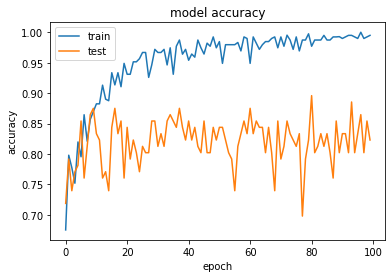

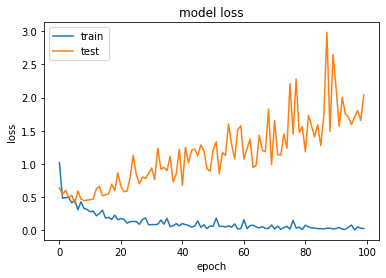

<Figure size 432x288 with 0 Axes>

In [36]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model-accuracy')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model-loss')